In [1]:
%load_ext autoreload
%autoreload 2
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from typing import List, Tuple, Dict, Union, Any, Optional
from tqdm import tqdm
import json
try:
    os.chdir(os.path.join(os.getcwd(), '../../Language-Technology-Project'))
    print(os.getcwd())
except:
    print("ALready in current dir")

c:\Users\mo\Documents\Organisations\RUG\Language-Technology-Project


In [2]:
df = pd.read_csv("datasets/training_merged.csv")
df = df.drop(df.columns[0], axis=1)
df = df.dropna()

df_labels = df.loc[:, df.columns != "Merged"]
df_labels = df_labels.astype(int)
df_labels = df_labels.values.tolist()
df_labels = torch.tensor(df_labels)
df_labels = df_labels.to(torch.float32)

df_inputs = df["Merged"].to_list()
df.head(3)

,Merged,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,we should ban human cloning as it will only ca...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,fast food should be banned because it is reall...,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,sometimes economic sanctions are the only thin...,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sentence_transformers import SentenceTransformer

class HumanValuesDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, labels, device):
        self.inputs = inputs
        self.labels = labels
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2').to(device)
        self.__preprocess()
        
    def __preprocess(self):
        self.inputs = self.model.encode(self.inputs, show_progress_bar=True)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

In [4]:
data_loader = torch.utils.data.DataLoader(
    HumanValuesDataset(df_inputs, df_labels, torch.device('cuda:0')),
    batch_size=1024,
    shuffle=True,
    num_workers=0,
)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

In [5]:
def load_data(path):
    df = pd.read_csv(path)
    df = df.drop(df.columns[0], axis=1)
    df = df.dropna()

    df_labels = df.loc[:, df.columns != "Merged"]
    df_labels = df_labels.astype(int)
    df_labels = df_labels.values.tolist()
    df_labels = torch.tensor(df_labels)
    df_labels = df_labels.to(torch.float32)

    df_inputs = df["Merged"].to_list()

    return df_inputs, df_labels

def create_dataloader(path, device, batch_size=1024, shuffle=True, num_workers=0, *args, **kwargs):
    df_inputs, df_labels = load_data(path)

    return torch.utils.data.DataLoader(
        HumanValuesDataset(df_inputs, df_labels, device),
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers,
        *args,
        **kwargs
    )

In [6]:
class HVClassifier(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
        self.fc1 = torch.nn.Linear(768, 128)
        self.bn1 = torch.nn.BatchNorm1d(128)
        self.dropout1 = torch.nn.Dropout(0.2)
        self.fc2 = torch.nn.Linear(128, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.fc3 = torch.nn.Linear(64, 32)
        self.bn3 = torch.nn.BatchNorm1d(32)
        self.dropout3 = torch.nn.Dropout(0.2)
        self.fc4 = torch.nn.Linear(32, 20)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.dropout1(torch.relu(self.bn1(self.fc1(x))))
        x = self.dropout2(torch.relu(self.bn2(self.fc2(x))))
        x = self.dropout3(torch.relu(self.bn3(self.fc3(x))))
        x = torch.sigmoid(self.fc4(x))
        return x
    
    def predict(self, x: List[str], return_type="pt") -> np.ndarray:
        x = self.model.encode(x, convert_to_tensor=True, device=next(self.parameters()).device)
        x = self.forward(x)
        x = x.cpu().detach()
        if return_type == "pt":
            return x
        elif return_type == "np":
            return x.numpy()

In [7]:
device = torch.device('cuda:0')
model = HVClassifier().to(device)

In [8]:
train_loader = create_dataloader("datasets/training_merged.csv", device)
val_loader = create_dataloader("datasets/validation_merged.csv", device)

Batches:   0%|          | 0/169 [00:00<?, ?it/s]

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

  0%|          | 0/1200 [00:00<?, ?it/s]

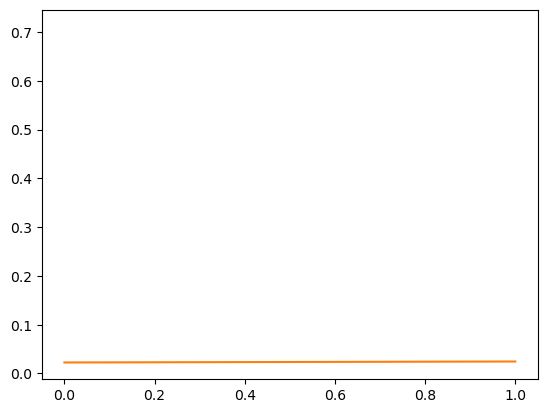

  0%|          | 3/1200 [00:00<01:32, 12.90it/s]

Epoch 1/1200 - loss: 0.7111438711484274, f1: 0.024541546687055316


  1%|          | 9/1200 [00:00<01:13, 16.26it/s]

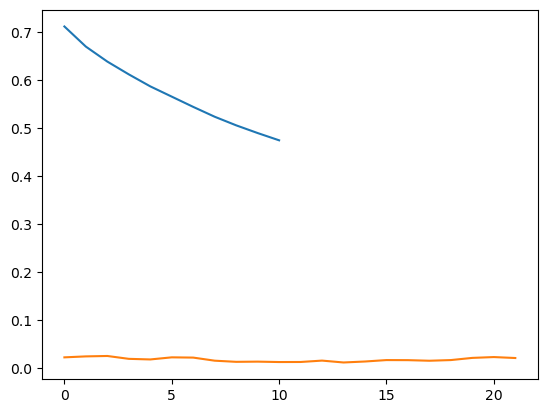

  1%|          | 13/1200 [00:00<01:16, 15.50it/s]

Epoch 11/1200 - loss: 0.4742281585931778, f1: 0.021157371401571434


  2%|▏         | 19/1200 [00:01<01:08, 17.22it/s]

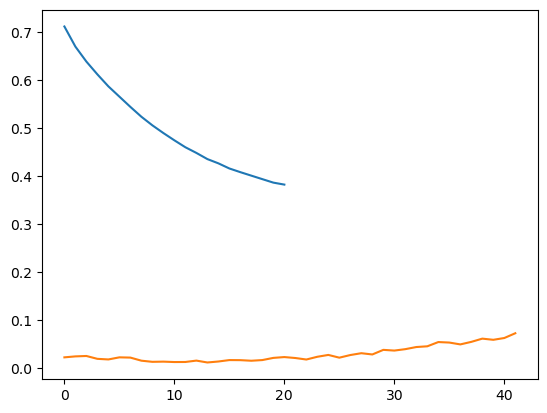

  2%|▏         | 23/1200 [00:01<01:14, 15.85it/s]

Epoch 21/1200 - loss: 0.3820623407761256, f1: 0.07271037112522324


  2%|▏         | 29/1200 [00:01<01:24, 13.85it/s]

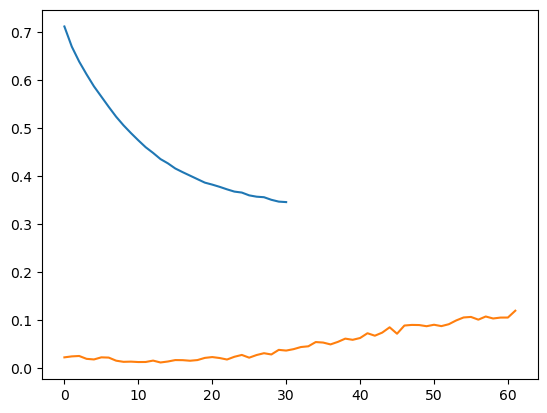

  3%|▎         | 33/1200 [00:02<01:23, 13.92it/s]

Epoch 31/1200 - loss: 0.3456567128499349, f1: 0.11961471100929255


  3%|▎         | 39/1200 [00:02<01:13, 15.82it/s]

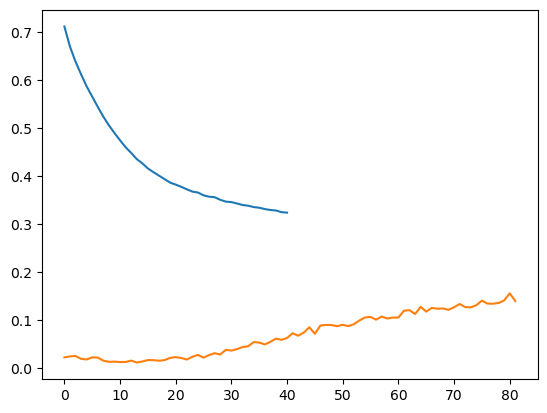

  4%|▎         | 43/1200 [00:02<01:18, 14.78it/s]

Epoch 41/1200 - loss: 0.32372873028119403, f1: 0.13957265325644042


  4%|▍         | 49/1200 [00:03<01:12, 15.90it/s]

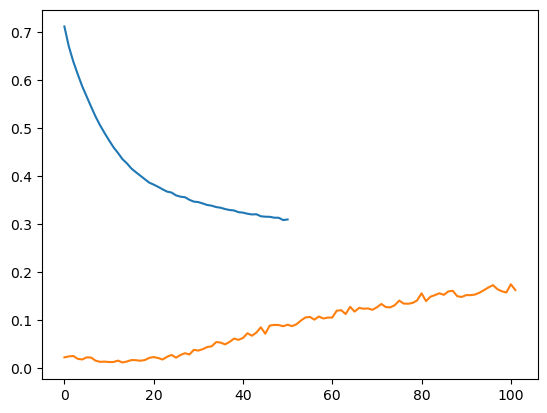

  4%|▍         | 53/1200 [00:03<01:18, 14.66it/s]

Epoch 51/1200 - loss: 0.3094978580872218, f1: 0.1626823418282048


  5%|▍         | 59/1200 [00:04<01:23, 13.75it/s]

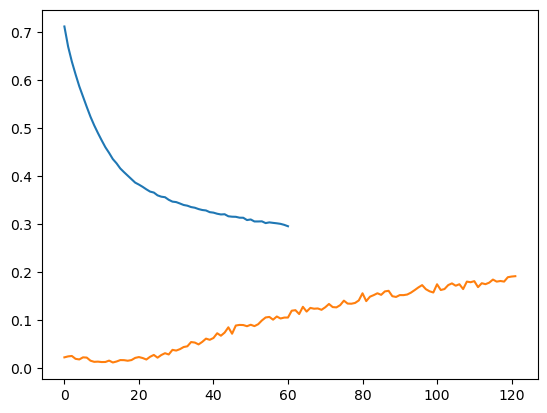

  5%|▌         | 63/1200 [00:04<01:22, 13.72it/s]

Epoch 61/1200 - loss: 0.29541254540284473, f1: 0.19146459164882654


  6%|▌         | 69/1200 [00:04<01:09, 16.16it/s]

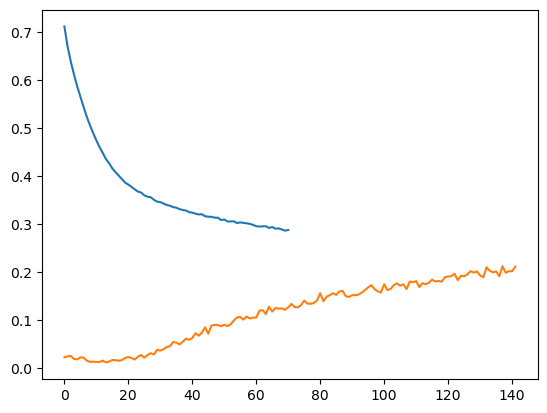

  6%|▌         | 73/1200 [00:04<01:13, 15.26it/s]

Epoch 71/1200 - loss: 0.28759720424811047, f1: 0.2112639681590994


  7%|▋         | 79/1200 [00:05<01:10, 15.81it/s]

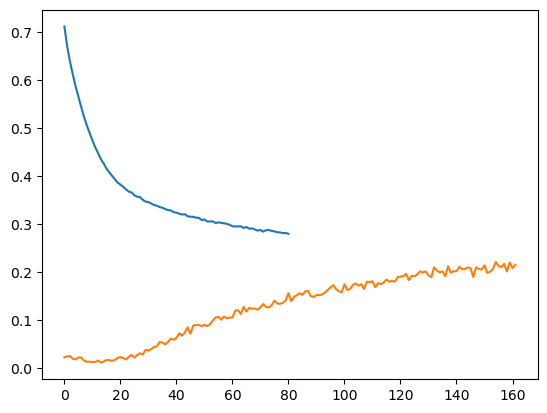

  7%|▋         | 83/1200 [00:05<01:18, 14.24it/s]

Epoch 81/1200 - loss: 0.27959001064300537, f1: 0.21502436997990454


  7%|▋         | 89/1200 [00:06<01:30, 12.27it/s]

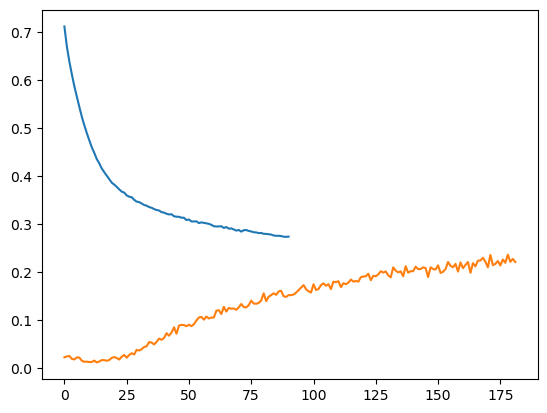

  8%|▊         | 93/1200 [00:06<01:25, 12.91it/s]

Epoch 91/1200 - loss: 0.27378275493780774, f1: 0.22090543622214964


  8%|▊         | 99/1200 [00:06<01:15, 14.50it/s]

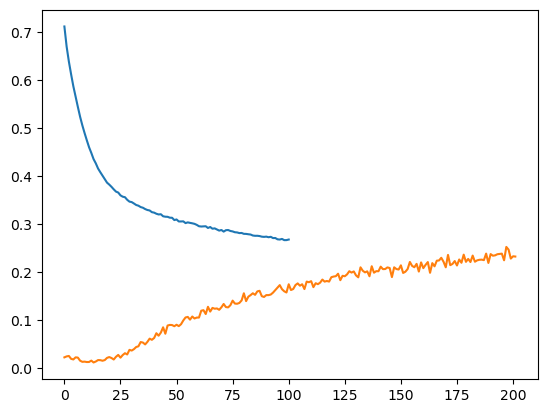

  9%|▊         | 103/1200 [00:07<01:18, 13.91it/s]

Epoch 101/1200 - loss: 0.26773161192735034, f1: 0.2323437731696471


  9%|▉         | 109/1200 [00:07<01:11, 15.23it/s]

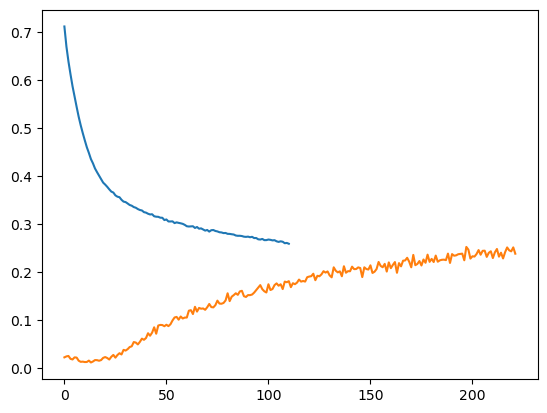

  9%|▉         | 113/1200 [00:07<01:16, 14.26it/s]

Epoch 111/1200 - loss: 0.25895590831836063, f1: 0.23827261889486331


 10%|▉         | 119/1200 [00:08<01:13, 14.76it/s]

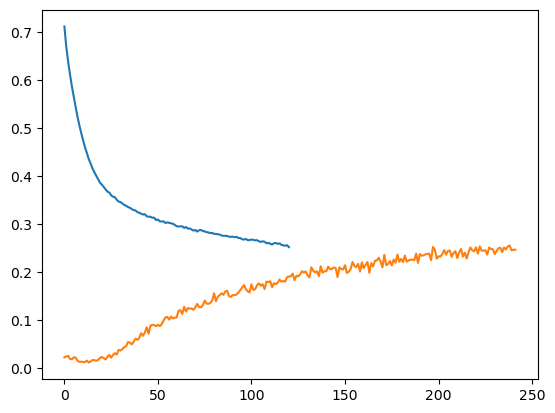

 10%|█         | 121/1200 [00:08<01:18, 13.78it/s]

Epoch 121/1200 - loss: 0.25186769167582196, f1: 0.24638468871364125


 11%|█         | 129/1200 [00:08<01:08, 15.52it/s]

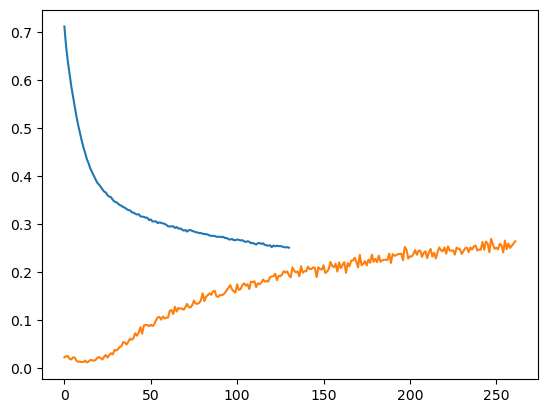

 11%|█         | 133/1200 [00:09<01:14, 14.40it/s]

Epoch 131/1200 - loss: 0.2507655421892802, f1: 0.2641592999466214


 12%|█▏        | 139/1200 [00:09<01:05, 16.29it/s]

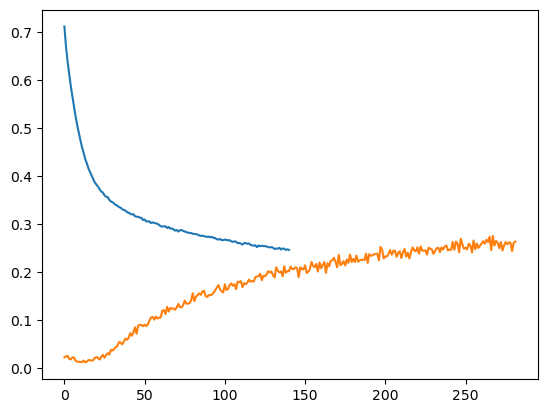

 12%|█▏        | 143/1200 [00:09<01:07, 15.55it/s]

Epoch 141/1200 - loss: 0.24610436211029688, f1: 0.2634898504839042


 12%|█▏        | 149/1200 [00:10<01:04, 16.25it/s]

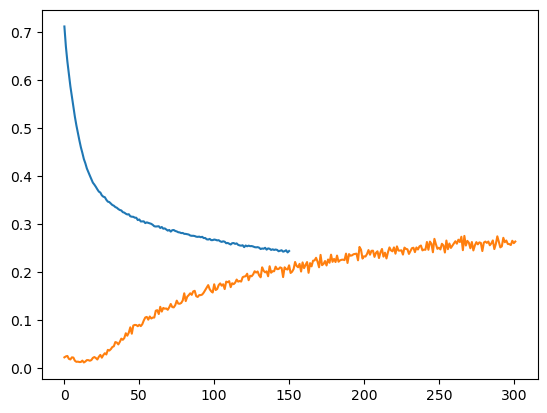

 13%|█▎        | 153/1200 [00:10<01:24, 12.34it/s]

Epoch 151/1200 - loss: 0.24386095503966013, f1: 0.2635676589812615


 13%|█▎        | 159/1200 [00:10<01:06, 15.66it/s]

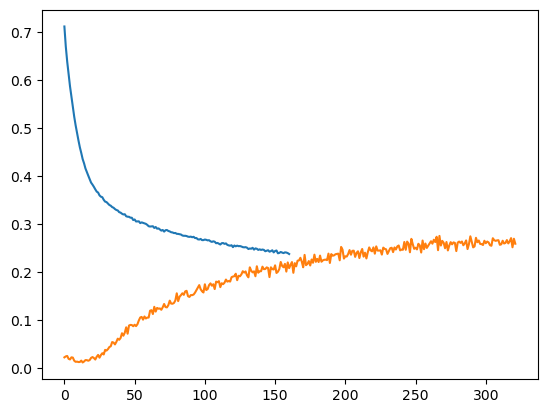

 14%|█▎        | 163/1200 [00:11<01:10, 14.69it/s]

Epoch 161/1200 - loss: 0.23762077341477075, f1: 0.2589841996408568


 14%|█▍        | 169/1200 [00:11<01:06, 15.58it/s]

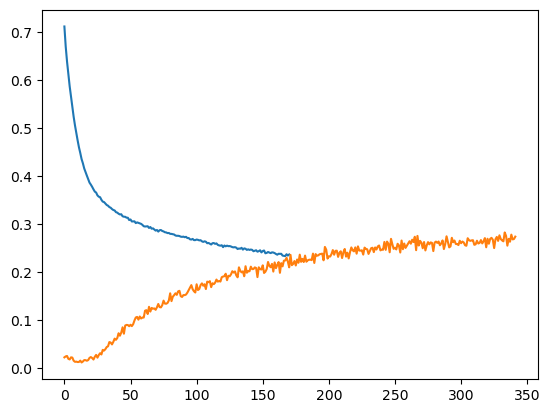

 14%|█▍        | 173/1200 [00:11<01:11, 14.34it/s]

Epoch 171/1200 - loss: 0.23662704726060232, f1: 0.2737759330396146


 15%|█▍        | 179/1200 [00:12<01:07, 15.14it/s]

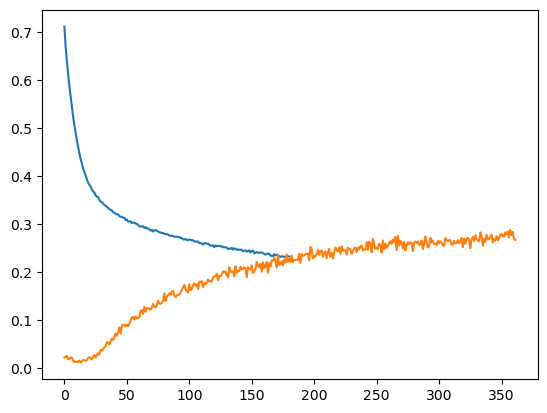

 15%|█▌        | 181/1200 [00:12<01:14, 13.76it/s]

Epoch 181/1200 - loss: 0.23238282154003778, f1: 0.26667343280395234


 16%|█▌        | 189/1200 [00:13<01:12, 13.85it/s]

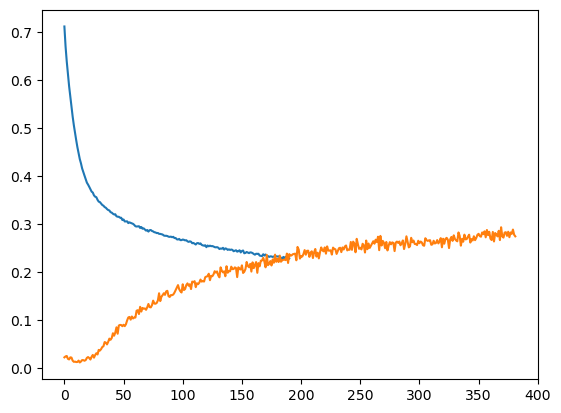

 16%|█▌        | 193/1200 [00:13<01:16, 13.20it/s]

Epoch 191/1200 - loss: 0.2284115677078565, f1: 0.2743681902321757


 17%|█▋        | 199/1200 [00:13<01:08, 14.63it/s]

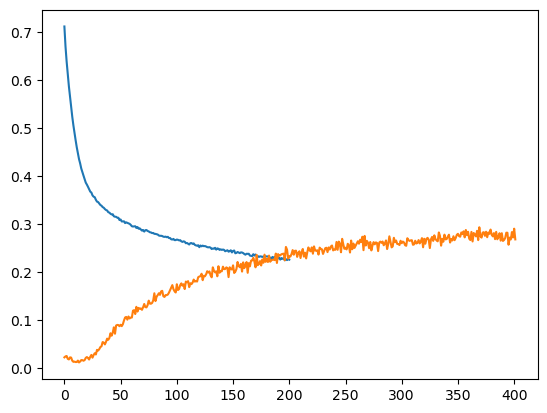

 17%|█▋        | 203/1200 [00:14<01:15, 13.25it/s]

Epoch 201/1200 - loss: 0.2258893276254336, f1: 0.26803267888933685


 17%|█▋        | 209/1200 [00:14<01:09, 14.20it/s]

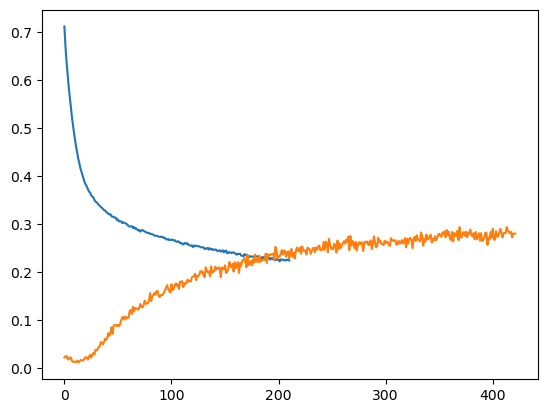

 18%|█▊        | 213/1200 [00:14<01:13, 13.47it/s]

Epoch 211/1200 - loss: 0.22412865857283273, f1: 0.28007443997208437


 18%|█▊        | 219/1200 [00:15<01:17, 12.70it/s]

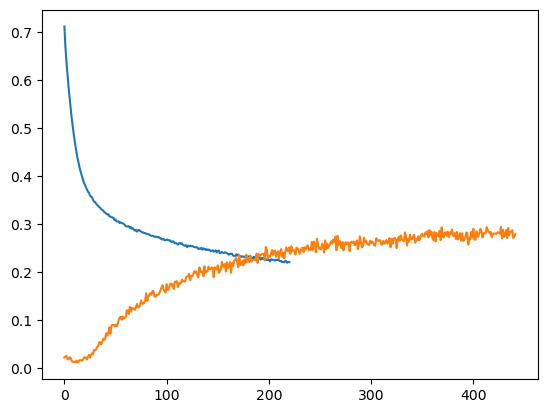

 19%|█▊        | 223/1200 [00:15<01:17, 12.66it/s]

Epoch 221/1200 - loss: 0.2208014875650406, f1: 0.2788205860969598


 19%|█▉        | 229/1200 [00:16<01:08, 14.18it/s]

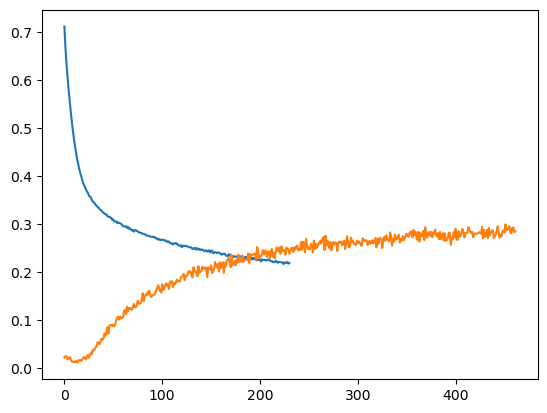

 19%|█▉        | 233/1200 [00:16<01:11, 13.46it/s]

Epoch 231/1200 - loss: 0.21892729898293814, f1: 0.2849221299581913


 20%|█▉        | 239/1200 [00:16<01:05, 14.70it/s]

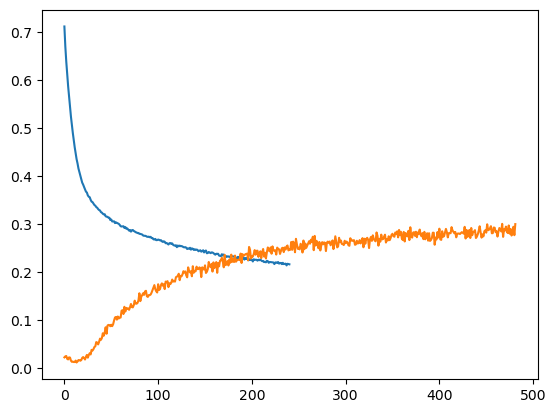

 20%|██        | 243/1200 [00:17<01:07, 14.09it/s]

Epoch 241/1200 - loss: 0.2161864017446836, f1: 0.299839860819241


 21%|██        | 249/1200 [00:17<01:08, 13.82it/s]

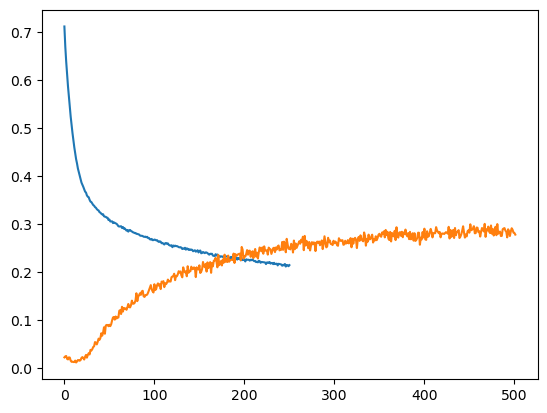

 21%|██        | 253/1200 [00:17<01:10, 13.46it/s]

Epoch 251/1200 - loss: 0.21442410349845886, f1: 0.2779900374619946


 22%|██▏       | 259/1200 [00:18<01:02, 14.94it/s]

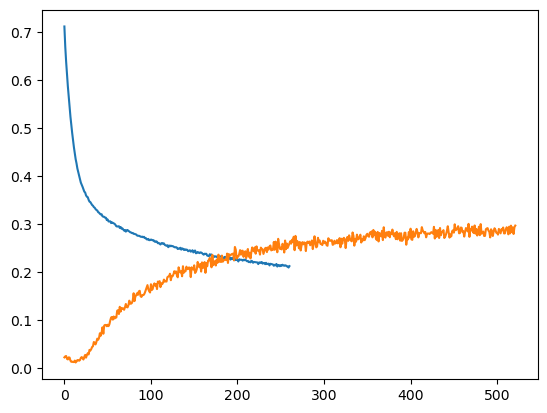

 22%|██▏       | 263/1200 [00:18<01:04, 14.54it/s]

Epoch 261/1200 - loss: 0.21234322587649027, f1: 0.2967823528165404


 22%|██▏       | 269/1200 [00:19<01:04, 14.51it/s]

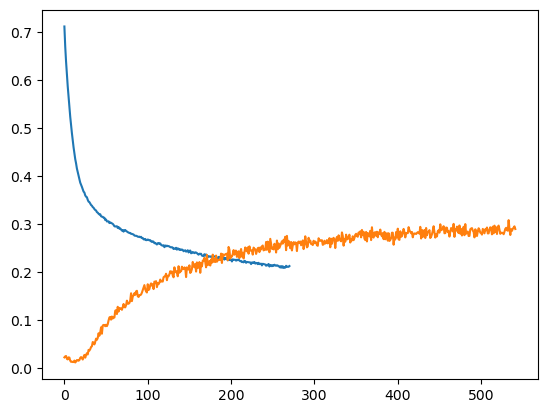

 23%|██▎       | 273/1200 [00:19<01:05, 14.08it/s]

Epoch 271/1200 - loss: 0.21254297842582068, f1: 0.28962191034683743


 23%|██▎       | 279/1200 [00:19<01:05, 13.97it/s]

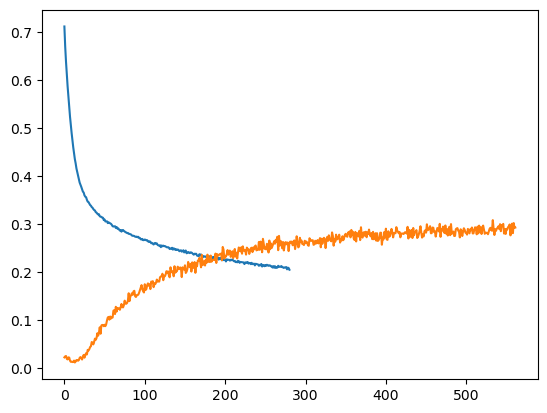

 24%|██▎       | 283/1200 [00:20<01:07, 13.69it/s]

Epoch 281/1200 - loss: 0.20487379531065622, f1: 0.2926512354000967


 24%|██▍       | 289/1200 [00:20<00:58, 15.63it/s]

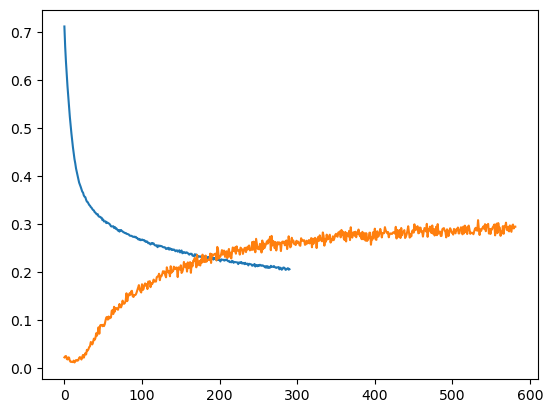

 24%|██▍       | 293/1200 [00:20<00:59, 15.19it/s]

Epoch 291/1200 - loss: 0.2060005764166514, f1: 0.29453578591237906


 25%|██▍       | 299/1200 [00:21<00:55, 16.28it/s]

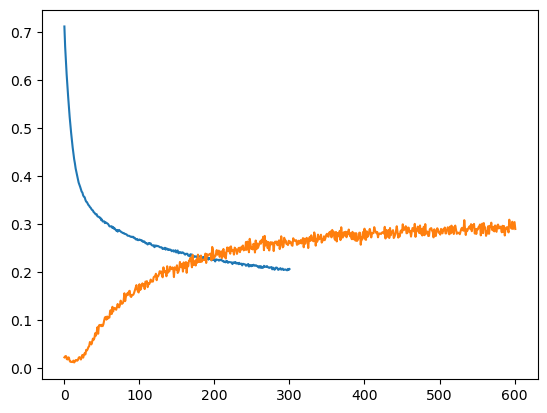

 25%|██▌       | 303/1200 [00:21<01:02, 14.43it/s]

Epoch 301/1200 - loss: 0.20623682936032614, f1: 0.28967870283771746


 26%|██▌       | 309/1200 [00:21<01:10, 12.67it/s]

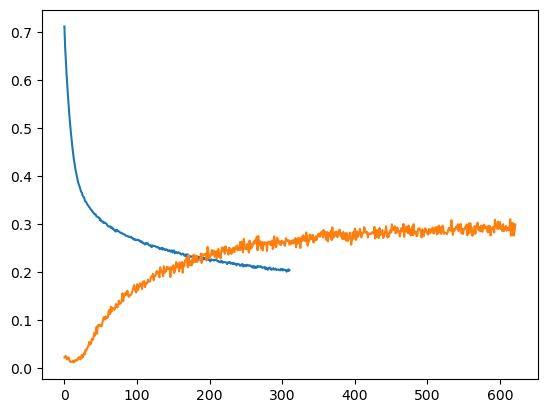

 26%|██▌       | 313/1200 [00:22<01:05, 13.60it/s]

Epoch 311/1200 - loss: 0.2038289631406466, f1: 0.2991778920327715


 27%|██▋       | 319/1200 [00:22<00:53, 16.36it/s]

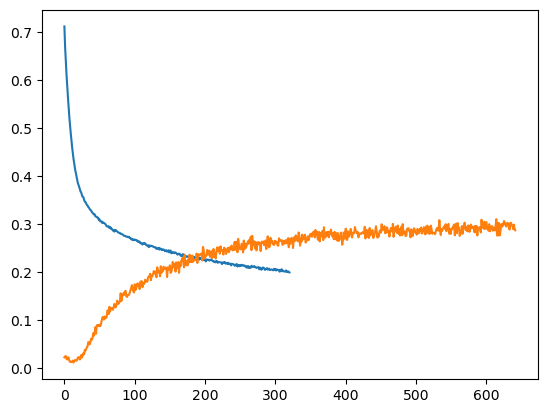

 27%|██▋       | 323/1200 [00:22<00:58, 15.07it/s]

Epoch 321/1200 - loss: 0.1992189586162567, f1: 0.2869053649195871


 27%|██▋       | 329/1200 [00:23<00:52, 16.57it/s]

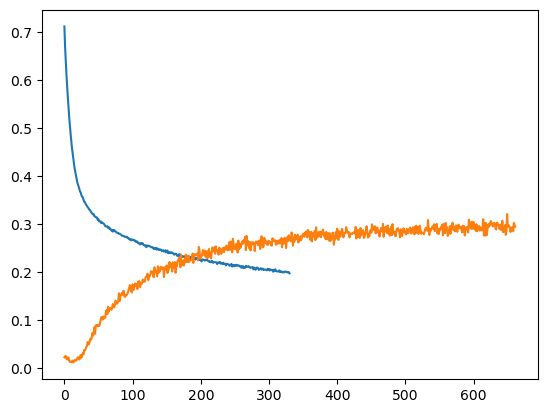

 28%|██▊       | 333/1200 [00:23<00:57, 15.01it/s]

Epoch 331/1200 - loss: 0.19750811407963434, f1: 0.29463279856508917


 28%|██▊       | 339/1200 [00:23<01:05, 13.14it/s]

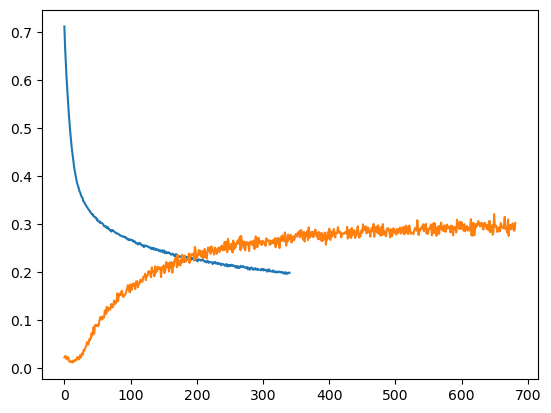

 29%|██▊       | 343/1200 [00:24<01:04, 13.26it/s]

Epoch 341/1200 - loss: 0.19865745306015015, f1: 0.30242172909393916


 29%|██▉       | 349/1200 [00:24<00:54, 15.53it/s]

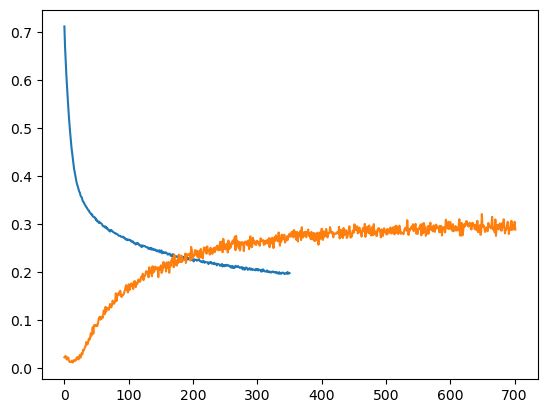

 29%|██▉       | 353/1200 [00:24<00:58, 14.54it/s]

Epoch 351/1200 - loss: 0.19774366666873297, f1: 0.28839545262703997


 30%|██▉       | 359/1200 [00:25<00:56, 14.92it/s]

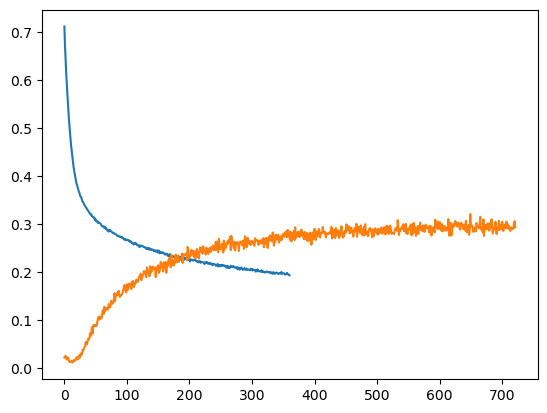

 30%|███       | 363/1200 [00:25<00:59, 14.02it/s]

Epoch 361/1200 - loss: 0.19331875195105871, f1: 0.29350428080379626


 31%|███       | 369/1200 [00:26<01:11, 11.68it/s]

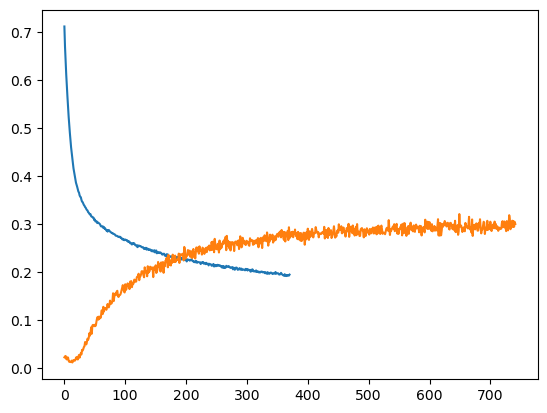

 31%|███       | 373/1200 [00:26<01:09, 11.87it/s]

Epoch 371/1200 - loss: 0.19475766271352768, f1: 0.30007954206442955


 32%|███▏      | 379/1200 [00:26<00:58, 14.01it/s]

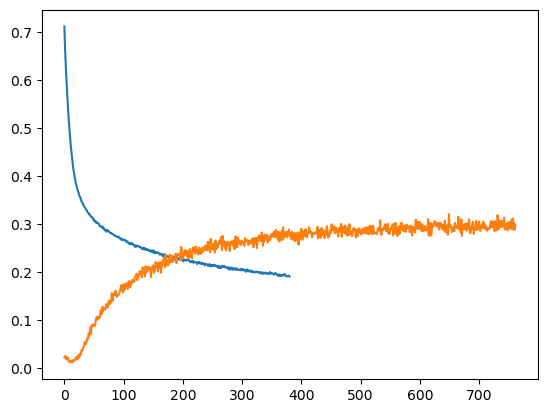

 32%|███▏      | 383/1200 [00:27<01:01, 13.25it/s]

Epoch 381/1200 - loss: 0.19079793244600296, f1: 0.2972754022534321


 32%|███▏      | 389/1200 [00:27<00:58, 13.98it/s]

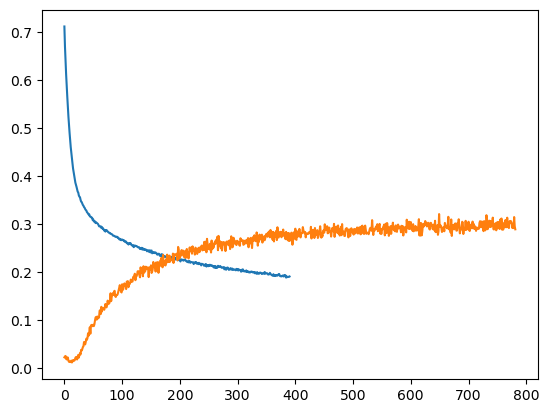

 33%|███▎      | 393/1200 [00:27<01:00, 13.25it/s]

Epoch 391/1200 - loss: 0.19076492389043173, f1: 0.2890089087109538


 33%|███▎      | 399/1200 [00:28<01:05, 12.28it/s]

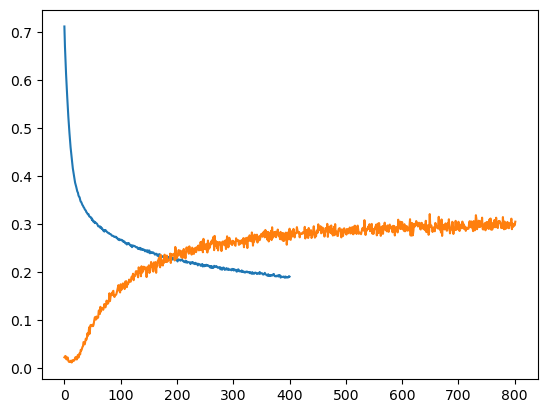

 34%|███▎      | 403/1200 [00:28<01:08, 11.70it/s]

Epoch 401/1200 - loss: 0.19049138824144998, f1: 0.30491306329217366


 34%|███▍      | 409/1200 [00:29<00:56, 14.10it/s]

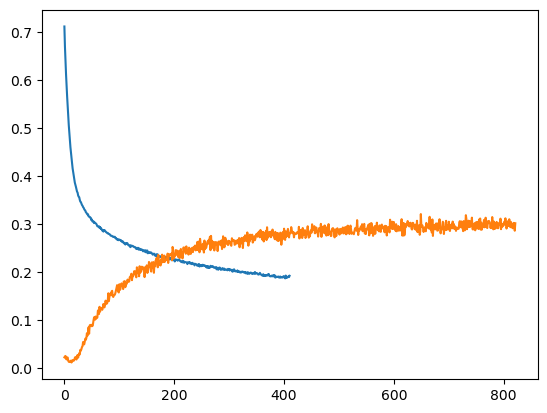

 34%|███▍      | 413/1200 [00:29<00:56, 13.87it/s]

Epoch 411/1200 - loss: 0.19232037415107092, f1: 0.30160615980690303


 35%|███▍      | 419/1200 [00:29<00:47, 16.51it/s]

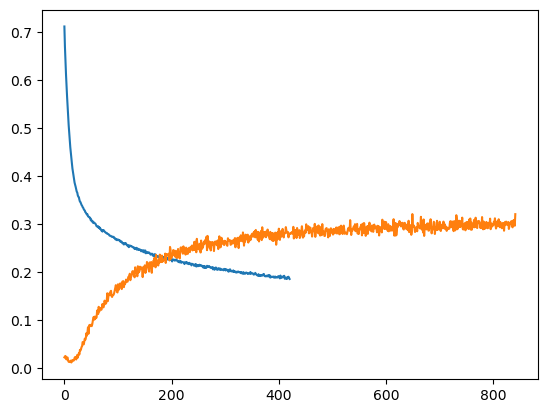

 35%|███▌      | 423/1200 [00:30<00:55, 14.04it/s]

Epoch 421/1200 - loss: 0.18564223249753317, f1: 0.3205657815756549


 36%|███▌      | 429/1200 [00:30<00:59, 13.03it/s]

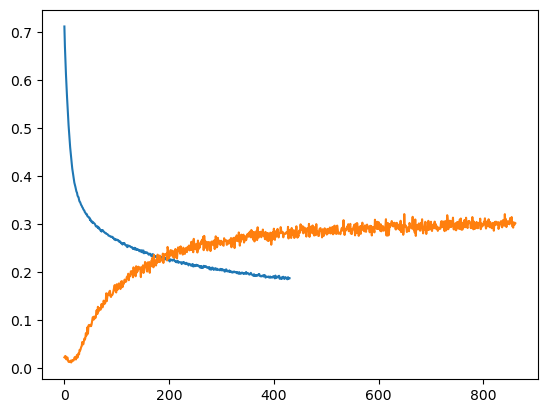

 36%|███▌      | 433/1200 [00:30<00:54, 13.99it/s]

Epoch 431/1200 - loss: 0.1872567037741343, f1: 0.3017833818178903


 37%|███▋      | 439/1200 [00:31<00:48, 15.82it/s]

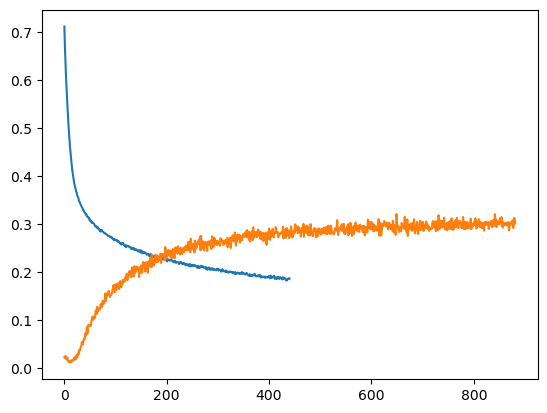

 37%|███▋      | 443/1200 [00:31<00:53, 14.14it/s]

Epoch 441/1200 - loss: 0.18646068374315897, f1: 0.3012724410794092


 37%|███▋      | 449/1200 [00:31<00:45, 16.68it/s]

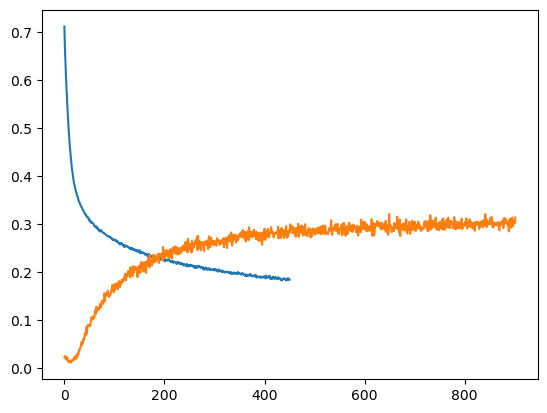

 38%|███▊      | 453/1200 [00:32<00:49, 15.04it/s]

Epoch 451/1200 - loss: 0.18436522781848907, f1: 0.31364339058766555


 38%|███▊      | 459/1200 [00:32<00:45, 16.20it/s]

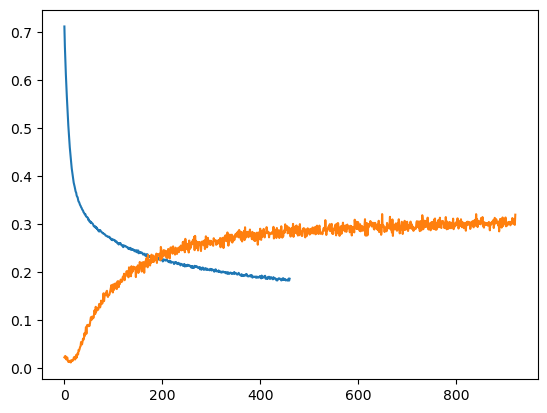

 39%|███▊      | 463/1200 [00:32<00:57, 12.77it/s]

Epoch 461/1200 - loss: 0.18621053049961725, f1: 0.319491612357575


 39%|███▉      | 469/1200 [00:33<00:47, 15.42it/s]

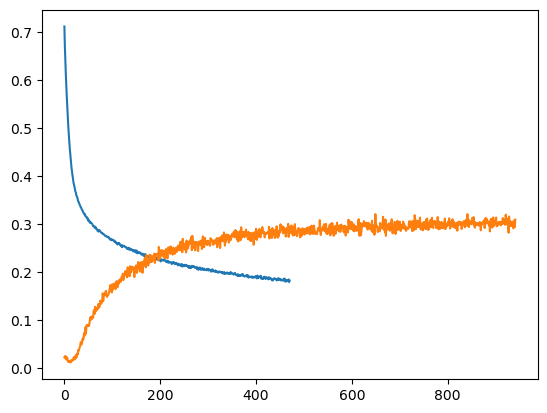

 39%|███▉      | 473/1200 [00:33<00:51, 14.00it/s]

Epoch 471/1200 - loss: 0.1822511355082194, f1: 0.3092002434278011


 40%|███▉      | 479/1200 [00:33<00:48, 14.83it/s]

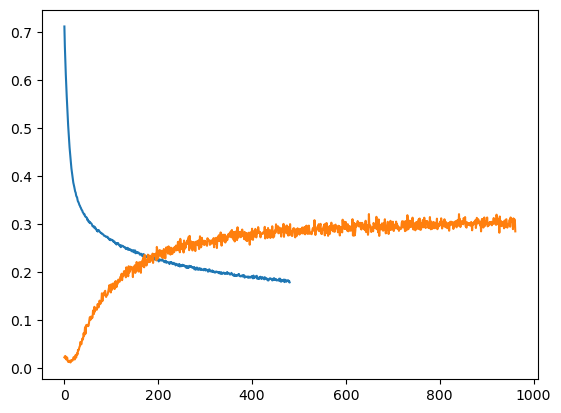

 40%|████      | 483/1200 [00:34<00:54, 13.22it/s]

Epoch 481/1200 - loss: 0.17868372052907944, f1: 0.2847294182930197


 41%|████      | 489/1200 [00:34<00:48, 14.75it/s]

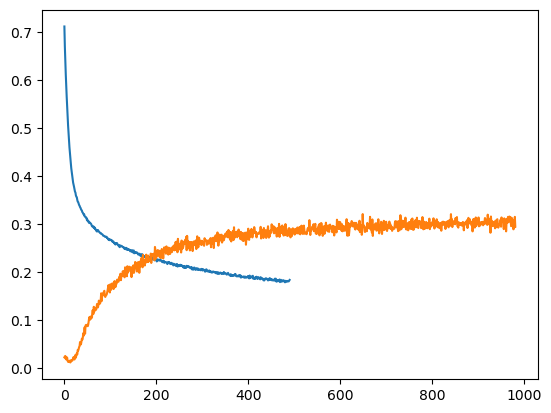

 41%|████      | 491/1200 [00:34<00:53, 13.31it/s]

Epoch 491/1200 - loss: 0.1836714173356692, f1: 0.29465806832036123


 42%|████▏     | 499/1200 [00:35<00:49, 14.16it/s]

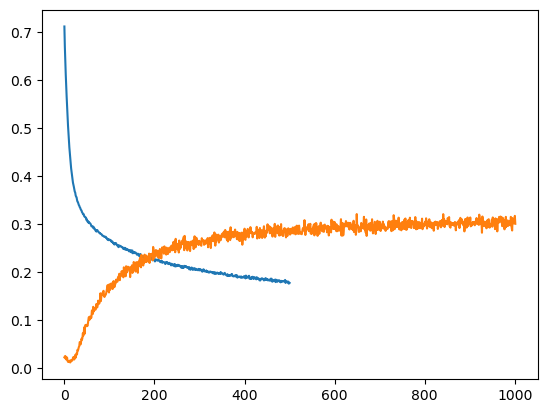

 42%|████▏     | 503/1200 [00:35<00:48, 14.26it/s]

Epoch 501/1200 - loss: 0.17747616519530615, f1: 0.3004280786387243


 42%|████▏     | 509/1200 [00:36<00:43, 15.82it/s]

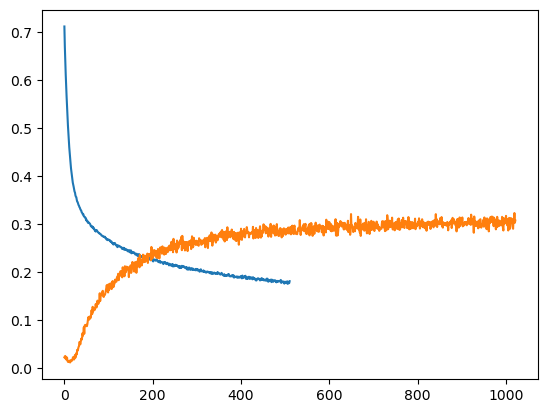

 43%|████▎     | 513/1200 [00:36<00:48, 14.24it/s]

Epoch 511/1200 - loss: 0.18107465406258902, f1: 0.30735218588438395


 43%|████▎     | 520/1200 [00:36<00:48, 14.09it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:21                                                                                   │
│                                                                                                  │
│   18 │   │   optimizer.zero_grad()                                                               │
│   19 │   │   outputs = model(inputs)                                                             │
│   20 │   │   loss = criterion(outputs, labels)                                                   │
│ ❱ 21 │   │   loss.backward()                                                                     │
│   22 │   │   optimizer.step()                                                                    │
│   23 │   │                                                                                       │
│   24 │   │   total_loss += loss.item()                                                           │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torch\_tensor.py:487 in backward             │
│                                                                                                  │
│    484 │   │   │   │   create_graph=create_graph,                                                │
│    485 │   │   │   │   inputs=inputs,                                                            │
│    486 │   │   │   )                                                                             │
│ ❱  487 │   │   torch.autograd.backward(                                                          │
│    488 │   │   │   self, gradient, retain_graph, create_graph, inputs=inputs                     │
│    489 │   │   )                                                                                 │
│    490                                                                                           │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torch\autograd\__init__.py:200 in backward   │
│                                                                                                  │
│   197 │   # The reason we repeat same the comment below is that                                  │
│   198 │   # some Python versions print out the first line of a multi-line function               │
│   199 │   # calls in the traceback and some print out the last line                              │
│ ❱ 200 │   Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the bac   │
│   201 │   │   tensors, grad_tensors_, retain_graph, create_graph, inputs,                        │
│   202 │   │   allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to ru   │
│   203                                                                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyboardInterrupt

In [10]:
criterion = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1200
losses = []
metrics = []

best_metric = 0

for epoch in tqdm(range(epochs)):

    total_loss = 0
    total_metric = 0
    
    # 
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        outputs = torch.where(outputs > 0.75, 1, 0)
        outputs = outputs.cpu().detach().numpy()
        labels = labels.cpu().detach().numpy()

        total_metric += f1_score(labels, outputs, average="weighted")

    losses.append(total_loss / len(data_loader))
    metrics.append(total_metric / len(val_loader))
    
    if epoch % 10 == 0:
        plt.plot(losses)
        plt.plot(metrics)
        plt.show()
        print(f"Epoch {epoch + 1}/{epochs} - loss: {losses[-1]}, f1: {metrics[-1]}")

    if metrics[-1] > best_metric:
        best_metric = metrics[-1]
        torch.save(model.state_dict(), "models/hv_classifier.pt")
        
losses = np.array(losses)
np.save("models/hv_classifier_losses.npy", losses)
plt.plot(losses)

In [ ]:

outputs = model.predict(df_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(df_labels, outputs, target_names=df.columns[:-1]))

                            precision    recall  f1-score   support

                    Merged       0.95      0.84      0.89       988
   Self-direction: thought       0.94      0.86      0.90      1395
    Self-direction: action       0.83      0.18      0.30       247
               Stimulation       0.86      0.22      0.35       172
                  Hedonism       0.93      0.88      0.90      1512
               Achievement       0.94      0.63      0.75       610
          Power: dominance       0.93      0.80      0.86       625
          Power: resources       0.91      0.26      0.41       382
                      Face       0.97      0.83      0.89      2000
        Security: personal       0.94      0.90      0.92      1728
        Security: societal       0.94      0.77      0.85       568
                 Tradition       0.93      0.79      0.85      1177
         Conformity: rules       0.97      0.55      0.70       207
 Conformity: interpersonal       0.91      0.52

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│   4 outputs = torch.where(outputs > 0.75, 1, 0)                                                  │
│   5                                                                                              │
│   6 print(classification_report(df_labels, outputs, target_names=df.columns[:-1]))               │
│ ❱ 7 print(confusion_matrix(df_labels, outputs))                                                  │
│   8 print(f1_score(df_labels, outputs, average="weighted"))                                      │
│   9                                                                                              │
│                                                                                                  │
│ c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:319 in    │
│ confusion_matrix                                                                                 │
│                                                                                                  │
│    316 │   """                                                                                   │
│    317 │   y_type, y_true, y_pred = _check_targets(y_true, y_pred)                               │
│    318 │   if y_type not in ("binary", "multiclass"):                                            │
│ ❱  319 │   │   raise ValueError("%s is not supported" % y_type)                                  │
│    320 │                                                                                         │
│    321 │   if labels is None:                                                                    │
│    322 │   │   labels = unique_labels(y_true, y_pred)                                            │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: multilabel-indicator is not supported

In [ ]:
validation_inputs, validation_labels = load_data("datasets/validation_merged.csv")

outputs = model.predict(validation_inputs)
outputs = torch.where(outputs > 0.75, 1, 0)

print(classification_report(validation_labels, outputs, target_names=df.columns[:-1]))


                            precision    recall  f1-score   support

                    Merged       0.37      0.31      0.33       251
   Self-direction: thought       0.43      0.32      0.37       496
    Self-direction: action       0.00      0.00      0.00       138
               Stimulation       0.00      0.00      0.00       103
                  Hedonism       0.56      0.40      0.46       575
               Achievement       0.09      0.05      0.06       164
          Power: dominance       0.11      0.11      0.11       132
          Power: resources       0.09      0.01      0.01       130
                      Face       0.65      0.42      0.51       759
        Security: personal       0.36      0.35      0.36       488
        Security: societal       0.33      0.19      0.24       172
                 Tradition       0.36      0.24      0.29       455
         Conformity: rules       0.16      0.05      0.08        60
 Conformity: interpersonal       0.07      0.02

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
